#  Entregable 2 - Aprendizaje Automático II


***<p style="text-align:center;">Combinación de Estimadores: Adaboost & Gradient Boosting</p>***

En este cuaderno vamos a implementar Adaboost para clasificar datos bi-clase, y Gradient Boosting para un problema de regresión.

* **Adaboost**: Usaremos el `Breast cancer wisconsin (diagnostic) dataset`de `Sklearn` descrito en el Anexo del Entregable 1.
* **Gradient Boosting**: Usaremos datos generados a partir de filtros de Gabor ya vistos en cuadernos anteriores.

### Normas de Entrega

1. El formato de entrega será en una carpeta comprimida con nombre: {Iniciales de Nombre y Apellidos}_E2.zip, en Aula Virtual en la fecha señalada en la plataforma y comunicada en clase previamente.
    * Por ejemplo: Iván Ramírez Díaz ==> `IRD_E2.zip`
2. El contenido de dicha carpeta será:
    * Obligatorio: Notebook relleno del Entregable 2.
    * Opcional: Memoria (pdf), en caso de necesitar dar alguna explicación.
3. Antes de la entrega, se debe comprobar que el código completo funciona.
4. La entrega es individual.

### Evaluación

La práctica entregable tiene un peso global de 1/4 puntos (los 4 entregables son el 10% de la nota final).

La práctica entregable se calificará sobre 10 puntos. Las puntuaciones son las siguientes:

- **[Ejercicio 1]** Usa **Adaboost** de `Sklearn` para clasificar los datos de `Breast Cancer Dataset` y visualiza el rendimiento del modelo en función del número de estimadores. (1 punto) 
- **[Ejercicio 2]** Implementa **Adaboost** a partir de la estructura (clase) propuesta y compara el resultado de la clasificación con la implementación de `Sklearn`. (1.5 puntos)
- **[Ejercicio 3]**  Usa **Gradient Boosting** de `Sklearn` para regresar los datos del filtro de Gabor (1 punto)
- **[Ejercicio 4]** Implementa **Gradient Boosting** a partir de la estructura (clase) propuesta y compara el resultado de la regresión con la implementación de `Sklearn`. (1.5 puntos)
- **[Ejercicio 5]** (2 puntos)
  ##### Crea un nuevo dataset 
  Crea un nuevo dataset con las siguientes características a partir de un modelo determinista (como el filtro de Gabor):
  1. El modelo  debe tener 2 variables $f(x_1, x_2)$ y devolver un escalar, es decir: $f: \mathbb{R}^2 \to \mathbb{R}$
  2. Los datos deben contener ruido gaussiano con $\sigma=0.1$. Es decir:
     $$y = f(x_1, x_2) + \eta, ~~~ \eta \sim \mathcal{N}(0, \sigma)$$
  3. Genera $100$ muestras $(x_1, x_2) \sim \mathcal{U}(\Omega)$, donde $\Omega = [-1,1] \times [-1,1]$.

- **[Ejercicio 6]** (1 punto)
  ##### Visualiza los datos:
 
     1. Representa en 3D la superficie del modelo ($f(x_1, x_2)$) sin ruido.
     2. Representa, en la misma gráfica 3D, las muestras ruidosas que has generado.
- **[Ejercicio 7]** Entrena y visualiza el resultado usando tu implementación de **Gradient Boosting**. (2 puntos)

# Adaboost

In [34]:
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Cargar el dataset
data = load_breast_cancer()
X = data.data
y = data.target

# Dividir el dataset en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

X_train += np.random.randn(*X_train.shape)

## **[Ejercicio 1]**
 
 Usa **Adaboost** de `Sklearn` para clasificar los datos de `Breast Cancer Dataset` y visualiza el rendimiento del modelo en función del número de estimadores.
 
 <font color='red'>Ten en cuenta que, `AdaBoostClassifier` está en proceso de deprecación en favor de `SAMME`</font>. 

In [35]:
# Importar clasificador Adaboost y weaklearner

############################ Completar ############################
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

# Inicializar el clasificador base (árbol de decisión con profundidad máxima 1)
base_estimator = DecisionTreeClassifier(max_depth=1)

# Inicializar el modelo AdaBoost con 50 clasificadores débiles
n_estimators = 50
ada_boost_sklearn = AdaBoostClassifier(estimator=base_estimator, n_estimators=n_estimators)

# Entrenar el modelo con los datos de entrenamiento
ada_boost_sklearn.fit(X_train, y_train)

# Hacer predicciones en el conjunto de prueba
y_pred_test = ada_boost_sklearn.predict(X_test)

########################## Fin Completar ##########################

# Calcular precisión en el conjunto de prueba
accuracy = accuracy_score(y_test, y_pred_test)
print(f"Precisión en el conjunto de prueba: {accuracy * 100:.2f}%")

Precisión en el conjunto de prueba: 95.91%


Visualiza la mejora del clasificador en función del número de estimadores:

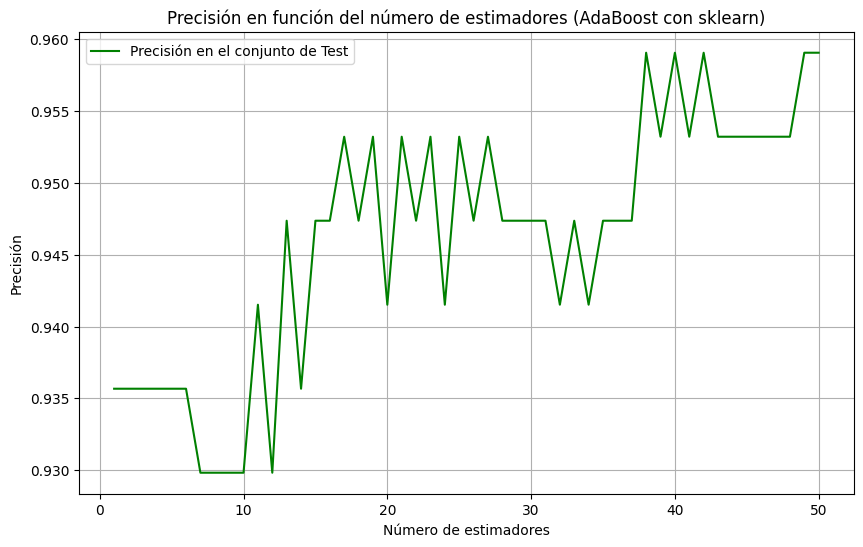

In [36]:
# Visualizar el número de estimadores vs precisión
n_estimators_list = range(1, 50+1)
accuracies = []

############################ Completar ############################

# Evaluar el rendimiento del modelo para cada número de estimadores
for n in n_estimators_list:
    ada_boost_partial = AdaBoostClassifier(estimator=base_estimator, n_estimators=n)
    ada_boost_partial.fit(X_train, y_train)
    y_pred_partial = ada_boost_partial.predict(X_test)
    accuracies.append(accuracy_score(y_test, y_pred_partial))

########################## Fin Completar ##########################

# Gráfica
plt.figure(figsize=(10, 6))
plt.plot(n_estimators_list, accuracies, label="Precisión en el conjunto de Test", color='green')
plt.xlabel('Número de estimadores')
plt.ylabel('Precisión')
plt.title("Precisión en función del número de estimadores (AdaBoost con sklearn)")
plt.legend()
plt.grid(True)
plt.show()

## **[Ejercicio 2]**

Implementa **Adaboost** a partir de la estructura (clase) propuesta y compara el resultado de la clasificación con la implementación de `Sklearn`.

Para ello, además de seguir la estructura siguiente, puedes apoyarte en la diapositiva 30 del Tema 3.

In [37]:
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

class AdaBoostClassifierManual:
    def __init__(self, n_estimators=50, max_depth=1):
        """
        Inicializa el modelo AdaBoost para clasificación.

        :param n_estimators: Número de estimadores a usar.
        :param max_depth: Profundidad máxima de los árboles base.
        """
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.models = []
        self.alphas = []

    def fit(self, X, y):
        """
        Ajusta el modelo a los datos de entrenamiento.

        :param X: Datos de entrenamiento.
        :param y: Vector de etiquetas de clase (-1, 1).
        """
        ############################ Completar ############################

        n_samples = X.shape[0] # Obtenemos el número de ejemplos a través de la dimensión de nuestra matriz
        weights = np.ones(n_samples) / n_samples  # Inicializa los pesos uniformemente (1/N)

        for _ in range(self.n_estimators):
            # Entrenar un clasificador débil con los pesos actuales
            model = DecisionTreeClassifier(max_depth=self.max_depth)    # Ten en cuenta que el clasificador débil debe admitir pesos para entrenar
            # scikit-learn trae en .fit la forma de incluir los pesos, sample_weight
            model.fit(X, y, sample_weight=weights)            # Fit
            y_pred = model.predict(X)

            # Calcular el error ponderado (solo en las predicciones incorrectas)
            error = np.sum(weights * (y_pred != y)).clip(0, 1)  # suma de errores ponderados

            # Calcular alpha (si error == 0, se para el ciclo)
            if error == 0:
                break
            alpha = 0.5 * np.log((1 - error) / (error+1e-10))
            
            self.models.append(model)
            self.alphas.append(alpha)

            # Actualizar los pesos para las muestras
            weights= weights * np.exp(-alpha * y * y_pred)
            weights /= np.sum(weights)
        ########################## Fin Completar ###########################

    def predict(self, X):
        """
        Realiza predicciones con el modelo ajustado.

        :param X: Matriz de características para predecir.
        :return: Predicciones del modelo (-1 o 1).
        """
        y_pred = np.zeros(X.shape[0])
        for model, alpha in zip(self.models, self.alphas):
            y_pred += alpha * model.predict(X)
        return np.sign(y_pred)


# IMPORTANTE: Adapta las etiquetas de {0, 1} a {-1, 1}
y_train = np.where(y_train == 0, -1, 1)
y_test = np.where(y_test == 0, -1, 1)

# Inicializar y entrenar el modelo AdaBoost 
ada_boost_manual = AdaBoostClassifierManual(n_estimators=50, max_depth=1)
ada_boost_manual.fit(X_train, y_train)

# Hacer predicciones en el conjunto de prueba
y_pred_test = ada_boost_manual.predict(X_test)

# Calcular precisión en el conjunto de prueba
accuracy = np.mean(y_pred_test == y_test)
print(f"Precisión en el conjunto de prueba: {accuracy * 100:.2f}%")

Precisión en el conjunto de prueba: 95.91%


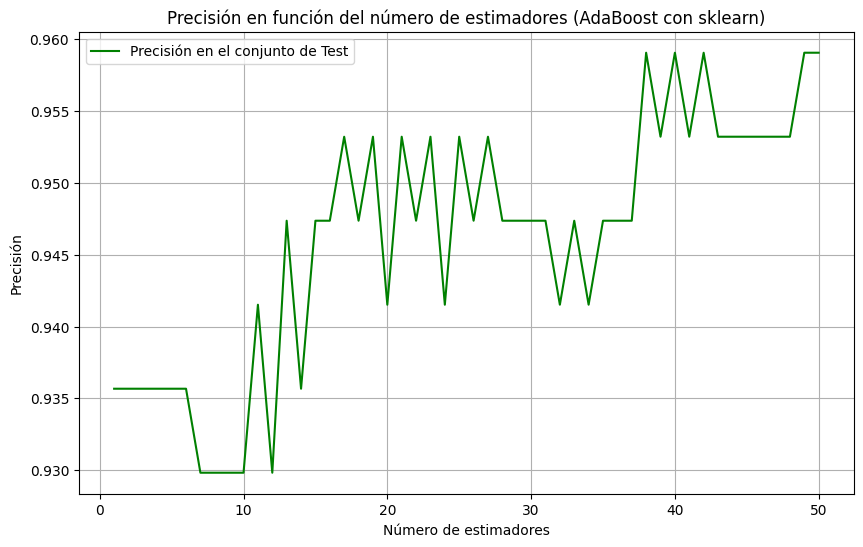

In [38]:
# Visualizar el número de estimadores vs precisión
n_estimators_list = range(1, 50+1)
accuracies = []

############################ Completar ############################

# Evaluar el rendimiento del modelo para cada número de estimadores
for n in n_estimators_list:
    ada_boost_partial = AdaBoostClassifierManual(n_estimators=n, max_depth=1)
    ada_boost_partial.fit(X_train, y_train)
    y_pred_partial = ada_boost_partial.predict(X_test)
    accuracies.append(accuracy_score(y_test, y_pred_partial))

########################## Fin Completar ##########################

# Gráfica
plt.figure(figsize=(10, 6))
plt.plot(n_estimators_list, accuracies, label="Precisión en el conjunto de Test", color='green')
plt.xlabel('Número de estimadores')
plt.ylabel('Precisión')
plt.title("Precisión en función del número de estimadores (AdaBoost con sklearn)")
plt.legend()
plt.grid(True)
plt.show()

# Gradient Boosting

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

Creamos unos datos

In [40]:
data = np.array([[-1.920e+00,-1.422e+01,1.490e+00,-1.940e+00,-2.389e+00,-5.090e+00,
                 -8.861e+00,3.578e+00,-6.010e+00,-6.995e+00,3.634e+00,8.743e-01,
                 -1.096e+01,4.073e-01,-9.467e+00,8.560e+00,1.062e+01,-1.729e-01,
                  1.040e+01,-1.261e+01,1.574e-01,-1.304e+01,-2.156e+00,-1.210e+01,
                 -1.119e+01,2.902e+00,-8.220e+00,-1.179e+01,-8.391e+00,-4.505e+00],
                  [-1.051e+00,-2.482e-02,8.896e-01,-4.943e-01,-9.371e-01,4.306e-01,
                  9.577e-03,-7.944e-02 ,1.624e-01,-2.682e-01,-3.129e-01,8.303e-01,
                  -2.365e-02,5.098e-01,-2.777e-01,3.367e-01,1.927e-01,-2.222e-01,
                  6.352e-02,6.888e-03,3.224e-02,1.091e-02,-5.706e-01,-5.258e-02,
                  -3.666e-02,1.709e-01,-4.805e-02,2.008e-01,-1.904e-01,5.952e-01]]).T
print(f'data.shape: {data.shape}')

data.shape: (30, 2)


Recordamos que estos datos venían muestreados de un filtro de Gabor con unos parámetros concretos. Estos parámetros son los que queríamos estimar en los cuadernos anteriores. 

$$
y = \sin(\phi_0 + 0.06 \cdot \phi_1 \cdot x) \cdot \exp\left(-\frac{(\phi_0 + 0.06 \cdot \phi_1 \cdot x)^2}{32}\right) + \eta, \quad \eta \sim \mathcal{N}(\mu, \sigma)
$$

donde $ \phi = [\phi_0, \phi_1] $ son los parámetros del modelo que controlan la fase y la frecuencia.


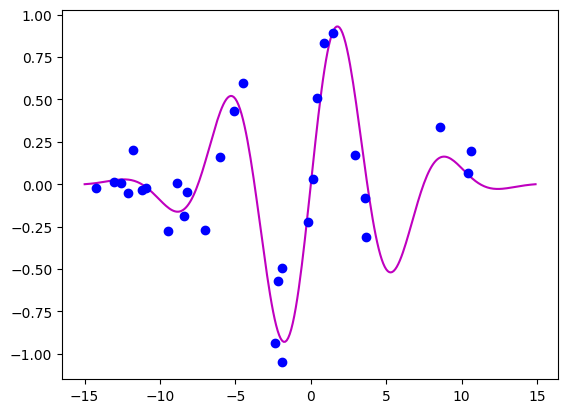

In [41]:
def model(phi,x):
    sin_component = np.sin(phi[0] + 0.06 * phi[1] * x)
    gauss_component = np.exp(-(phi[0] + 0.06 * phi[1] * x) * (phi[0] + 0.06 * phi[1] * x) / 32)
    y_pred= sin_component * gauss_component
    return y_pred

# Visualización
x =  np.arange(-15,15,0.1)
y_model = model([0,14], x)
plt.plot(x, y_model,'m-')
plt.plot(data[:,0], data[:,1], 'bo')
plt.show()

## **[Ejercicio 3]**

Usa **Gradient Boosting** de `Sklearn` para regresar los datos del filtro de Gabor.


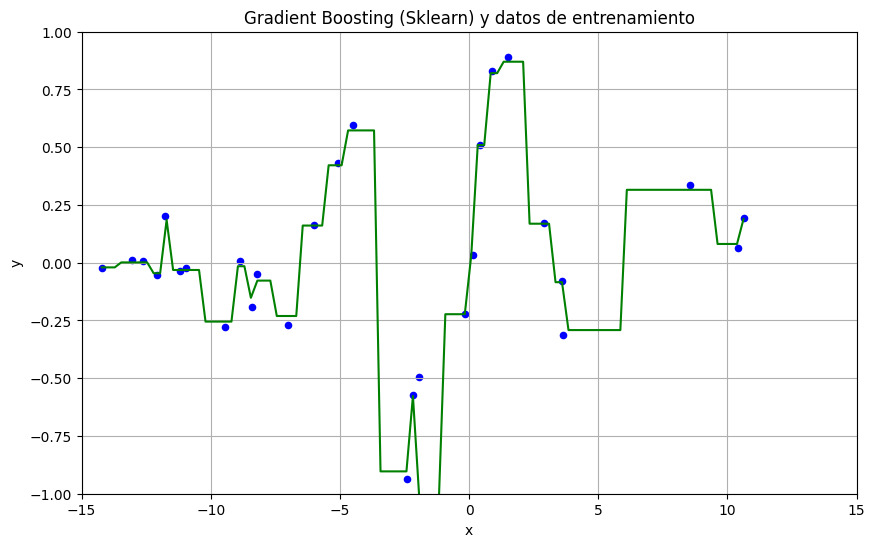

In [42]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
# --------- DATOS ---------
# Variables de entrada (X) y salida (y)
X = data[:, 0].reshape(-1, 1)
y = data[:, 1]

# --------- MODELO DE SKLEARN: Gradient Boosting ---------

############################ Completar ############################

# 1. Entrenar el modelo con sklearn
gbr = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3)
gbr.fit(X, y)

# 2. Conjunto de test (valores nuevos en los que queremos predecir)
x_test = np.linspace(np.min(X), np.max(X), 100).reshape(-1, 1)

# 3. Hacer predicciones con el modelo de sklearn
y_pred_sklearn_test = gbr.predict(x_test)

########################## Fin Completar ###########################

# 4. Comparar las predicciones en el conjunto de test
fig, ax = plt.subplots(figsize=(10, 6))

# Scatter plot de las predicciones del modelo de sklearn
ax.plot(x_test, y_pred_sklearn_test, label="Gradient Boosting (sklearn)", color='green')

# Scatter plot de los puntos de entrenamiento
ax.scatter(X, y, label="Train", color='blue', s=20)


# Establecemos los límites de los ejes en el rango x e y
ax.set_xlim([-15,15]);ax.set_ylim([-1,1])
ax.set_xlabel('x'); ax.set_ylabel('y')
ax.set_xlabel('x')
ax.set_ylabel('y')


ax.set_title("Gradient Boosting (Sklearn) y datos de entrenamiento")

plt.grid(True)

plt.show()

## **[Ejercicio 4]** 

Implementa **Gradient Boosting** a partir de la estructura (clase) propuesta y compara el resultado de la regresión con la implementación de `Sklearn`.

Para ello, recordamos los pasos a seguir (diapositiva 61 - Tema 3):

1. **Inicialización**:
   - **General**:
     $$ f_0(x) = \gamma_0 = \arg\min_{\gamma} \sum_{i=1}^{N} L(y_i, \gamma) $$
   - **MSE**:
     $$ f_0(x) = \gamma_0 = \arg\min_{\gamma} \sum_{i=1}^{N} (y_i - \gamma)^2 $$
     **Solución**: Para MSE, la solución es la media de los valores de \( y \):
     $$ \gamma_0 = \frac{1}{N} \sum_{i=1}^{N} y_i $$

2. **Cálculo de los residuos**:
   - **General**:
     $$ r_{im} = -\left[\frac{\partial L(y_i, f_{m-1}(x_i))}{\partial f_{m-1}(x_i)}\right] $$
   - **MSE**:
     $$ r_{im} = y_i - f_{m-1}(x_i) $$
     **Solución**: Para MSE, los residuos son simplemente la diferencia entre los valores reales y las predicciones actuales.

3. **Ajuste del modelo**:
   - **General**:
     $$ f_m(x) = \arg\min_{f} \sum_{i=1}^{N} L(r_{im}, f(x_i)) $$
   - **MSE**:
     $$ f_m(x) = \arg\min_{f} \sum_{i=1}^{N} (r_{im} - f(x_i))^2 = \arg\min_{f} \sum_{i=1}^{N} (y_i - f_{m-1}(x_i) - f(x_i))^2 $$
     **Solución**: Para MSE, se entrena un modelo \( f_m(x) \) para predecir los residuos \( r_{im} \).

4. **Optimización del valor de $\gamma_m$**:
   - **General**:
     $$ \gamma_m = \arg\min_{\gamma} \sum_{i=1}^{N} L(y_i, f_{m-1}(x_i) + \gamma f_m(x_i)) $$
   - **MSE**:
     $$ \gamma_m = \arg\min_{\gamma} \sum_{i=1}^{N} (y_i - (f_{m-1}(x_i) + \gamma f_m(x_i)))^2 $$
     **Solución**: Para MSE, la solución es:
     $$ \gamma_m = \frac{\sum_{i=1}^{N} r_{im} f_m(x_i)}{\sum_{i=1}^{N} f_m(x_i)^2} $$

5. **Actualización**:
   
     $$ f_m(x) = f_{m-1}(x) + \alpha \gamma_m f_m(x) $$
   



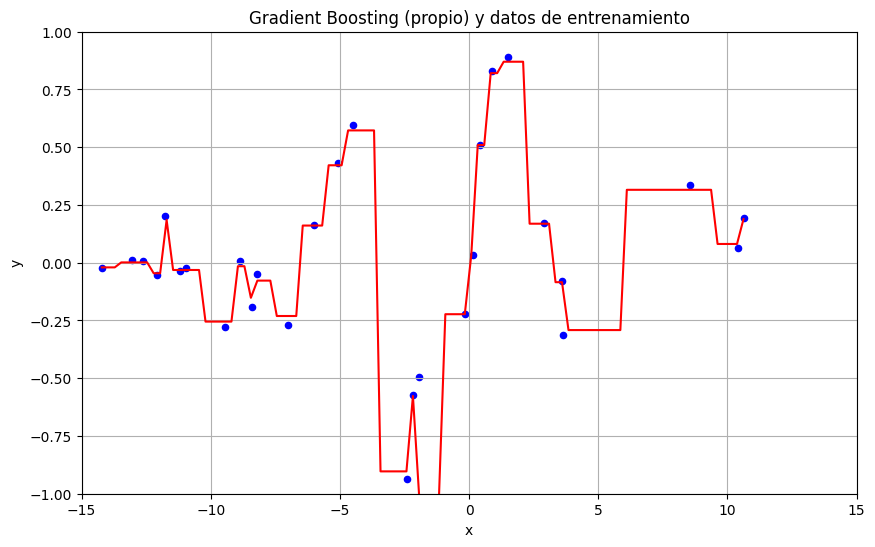

In [43]:
import numpy as np
from sklearn.tree import DecisionTreeRegressor

class GradientBoostingManual:
    def __init__(self, n_estimators=100, learning_rate=0.1, max_depth=3, loss='mse'):
        """
        Inicializa el modelo de boosting.
        
        :param n_estimators: Número de iteraciones (árboles) que se entrenarán.
        :param learning_rate: Tasa de aprendizaje .
        :param max_depth: Profundidad máxima de los árboles de decisión (weak learners).
        :param loss: Función de pérdida, se usará 'mse' por defecto (error cuadrático medio).
        """
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.loss = loss  # Solo soportaremos 'mse' en esta implementación
        self.trees = []  # Lista para almacenar los árboles (weak learners)
        self.gammas = []  # Lista para almacenar los multiplicadores gamma

    def _mse_gradient(self, y, y_pred):
        ############################ Completar ############################
        """Calcula el gradiente de la función de pérdida MSE."""
        return y - y_pred # Gradiente negativo para MSE
        ########################## Fin Completar ###########################

    def _mse_loss(self, y, y_pred):
        ############################ Completar ############################

        """Calcula el error cuadrático medio (MSE)."""
        return np.mean((y - y_pred) ** 2)
        ########################## Fin Completar ###########################
    
    def fit(self, X, y):
        """
        Entrena el modelo de Gradient Boosting manualmente.
        
        :param X: Matriz de características (features).
        :param y: Vector de salida (target).
        """
        ############################ Completar ############################

        # Inicializar modelo (y_pred) con un valor constante (la media de los valores de y)
        y_pred = np.mean(y)
        
        self.initial_value = y_pred # guarda esta inicialización
        y_pred = np.full(y.shape[0], self.initial_value)   # inicializa el vector de predicciones al valor anterior (cada componente)

        # Iterar para crear n_estimators árboles
        for m in range(self.n_estimators):
            # 1. Calcular los pseudo-residuos (gradiente negativo de la función de pérdida)
            residuals = self._mse_gradient(y, y_pred)
            
            # 2. Entrenar un nuevo árbol en los residuos
            tree = DecisionTreeRegressor(max_depth=self.max_depth).fit(X, residuals)
            
            self.trees.append(tree)
            
            # 3. Calcular la predicción del nuevo árbol
            tree_pred = tree.predict(X)
            
            # 4. Optimizar el valor de gamma para la iteración actual
            gamma_m = self._compute_gamma(y, y_pred, tree_pred)
            self.gammas.append(gamma_m)
            
            # 5. Actualizar las predicciones del modelo sumando el escalado de gamma_m y el árbol actual
            y_pred = y_pred + gamma_m * tree_pred * self.learning_rate

        ########################## Fin Completar ###########################

    def _compute_gamma(self, y, y_pred, tree_pred):
        """
        Optimiza el valor de gamma_m para minimizar la función de pérdida en la iteración actual.
        
        :param y: Valores reales.
        :param y_pred: Predicciones actuales.
        :param tree_pred: Predicciones del nuevo árbol.
        :return: El valor óptimo de gamma_m.
        """
        ############################ Completar ############################

        # Para MSE, gamma se optimiza mediante la fórmula cerrada del enunciado
        residuals = self._mse_gradient(y, y_pred)
        
        numerator = np.sum(residuals * tree_pred)
        denominator = np.sum(tree_pred ** 2)

        ########################## Fin Completar ###########################

        if denominator == 0:
            return 0  # Si el denominador es cero, devolver gamma = 0 para evitar división por cero
        
        return numerator / denominator
        
    def predict(self, X):
        """
        Realiza predicciones utilizando el modelo entrenado.
        
        :param X: Matriz de características (features) sobre las que se quiere predecir.
        :return: Predicciones del modelo.
        """        
        ############################ Completar ############################

        # Inicializamos las predicciones con el valor constante inicial
        y_pred = np.full(X.shape[0], self.initial_value)

        # Sumamos las contribuciones de cada árbol multiplicadas por su gamma correspondiente
        for tree, gamma in zip(self.trees, self.gammas):
            y_pred = y_pred + tree.predict(X)*gamma*self.learning_rate

        ########################## Fin Completar ###########################
        return y_pred



# Crear el modelo y entrenarlo
gbm_manual = GradientBoostingManual(n_estimators=50, learning_rate=0.1, max_depth=3)
gbm_manual.fit(X, y)

# Predecir en el conjunto de test
x_test = np.linspace(np.min(X), np.max(X), 100).reshape(-1, 1)
y_pred_manual_test = gbm_manual.predict(x_test)

# --------- GRÁFICO PARA VISUALIZAR ---------
fig, ax = plt.subplots(figsize=(10, 6))

# Scatter plot de las predicciones del modelo 
ax.plot(x_test, y_pred_sklearn_test, label="Gradient Boosting (implementación propia)", color='red')

# Scatter plot de los puntos de entrenamiento
ax.scatter(X, y, label="Train", color='blue', s=20)


# Establecemos los límites de los ejes en el rango x e y
ax.set_xlim([-15,15]);ax.set_ylim([-1,1])
ax.set_xlabel('x'); ax.set_ylabel('y')
ax.set_xlabel('x')
ax.set_ylabel('y')


ax.set_title("Gradient Boosting (propio) y datos de entrenamiento")

plt.grid(True)

plt.show()

## [Ejercicio 5]
  ##### Crea un nuevo dataset (2 puntos)
  Crea un nuevo dataset con las siguientes características a partir de un modelo determinista (como el filtro de Gabor):
  1. El modelo  debe tener 2 variables $f(x_1, x_2)$ y devolver un escalar, es decir: $f: \mathbb{R}^2 \to \mathbb{R}$
  2. Los datos deben contener ruido gaussiano con $\sigma=0.1$. Es decir:
     $$y = f(x_1, x_2) + \eta, ~~~ \eta \sim \mathcal{N}(0, \sigma)$$
  3. Genera $100$ muestras $(x_1, x_2) \sim \mathcal{U}(\Omega)$, donde $\Omega = [-1,1] \times [-1,1]$.

In [44]:
############################ Completar ############################
# Parámetros
N = 100
sigma = 0.1

# Dominio: [-1, 1] x [-1, 1]
x1 = np.random.uniform(low=-1, high=1, size=N)
x2 = np.random.uniform(low=-1, high=1, size=N)

# Modelo determinista
def f(x1, x2):
    # Gabor = Gaussiana * Coseno
    return np.exp(-(x1**2 + x2 ** 2)) * np.cos(2 * np.pi * x1) 
    # np.exp(-(x1**2 + x2 ** 2)) -> campana gaussiana
    # np.cos(2 * np.pi * x1) onda sinusoidal

# Datos con ruido gaussiano
y = f(x1, x2) + np.random.normal(scale=sigma, size=N)
########################## Fin Completar ###########################

## [Ejercicio 6]
  ##### Visualiza los datos: (1 punto)
  1. Representa en 3D la superficie del modelo ($f(x_1, x_2)$) sin ruido.
  2. Representa, en la misma gráfica 3D, las muestras ruidosas que has generado.

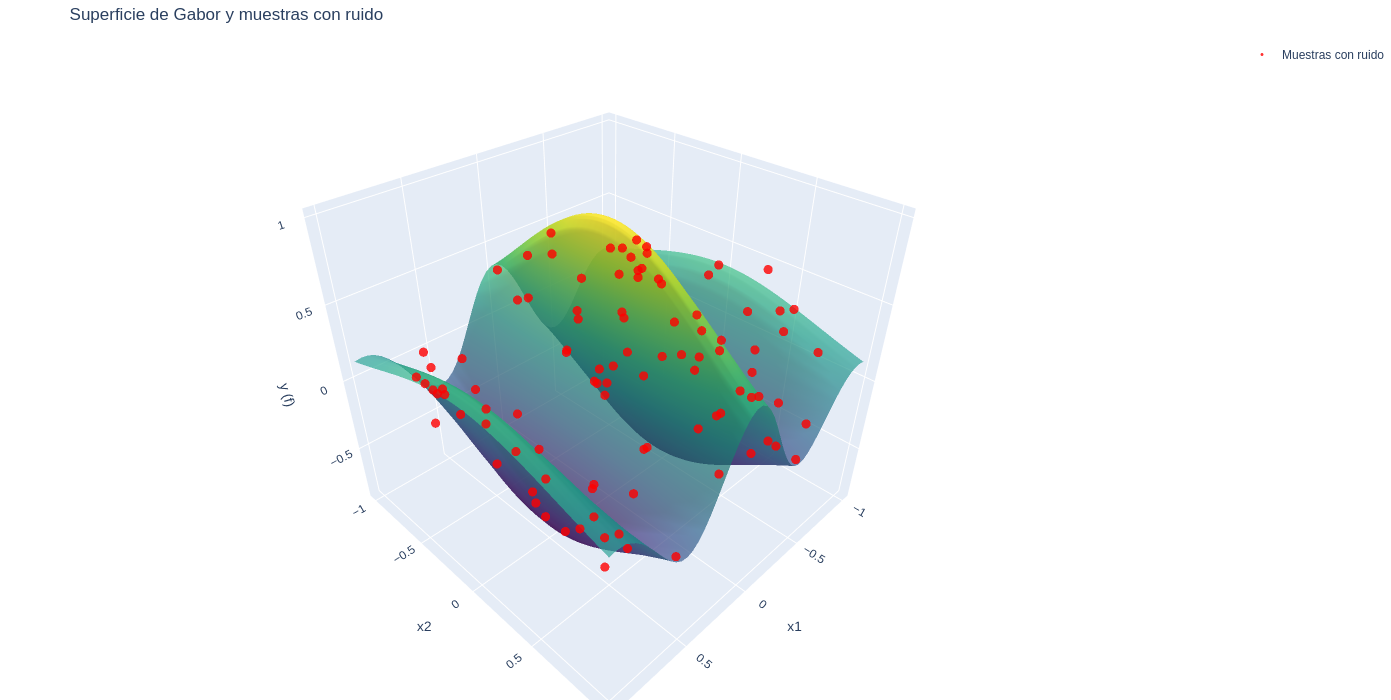

In [45]:
############################ Completar ############################
import plotly.graph_objects as go

# 1. Creamos la figura 3D
fig = go.Figure()

# superficie gabor sin ruido
fig.add_trace(go.Surface(
    x=X1_mesh,
    y=X2_mesh,
    z=Z_surf,               
    name='Superficie Gabor (Verdadera)',
    colorscale='Viridis',  
    opacity=0.7,
    showscale=False         
))

# muestras ruidosas
fig.add_trace(go.Scatter3d(
    x=x1,
    y=x2,
    z=y,
    mode='markers',
    marker=dict(
        size=3,
        color='red',     
        opacity=0.8
    ),
    name='Muestras con ruido'
))

# layout
fig.update_layout(
    title='Superficie de Gabor y muestras con ruido',
    width=800,  # Ancho
    height=700, # Alto
    margin=dict(l=0, r=0, b=0, t=40), # Márgenes mínimos
    
    scene=dict(
        xaxis_title="x1",
        yaxis_title="x2",
        zaxis_title="y (f)"
    ),
    showlegend=True
)

fig.show()
########################## Fin Completar ###########################

## [Ejercicio 7]
Entrena y visualiza el resultado usando tu implementación de **Gradient Boosting**. (2 puntos)

In [46]:
############################ Completar ############################
X_train = np.stack([x1, x2], axis=1)

gbm_manual = GradientBoostingManual(n_estimators=100, learning_rate=0.1, max_depth=4)
gbm_manual.fit(X_train, y)

X_grid_flat = np.c_[X1_mesh.ravel(), X2_mesh.ravel()] 

y_pred_flat = gbm_manual.predict(X_grid_flat) 
y_pred_grid = y_pred_flat.reshape(X1_mesh.shape)
########################## Fin Completar ###########################

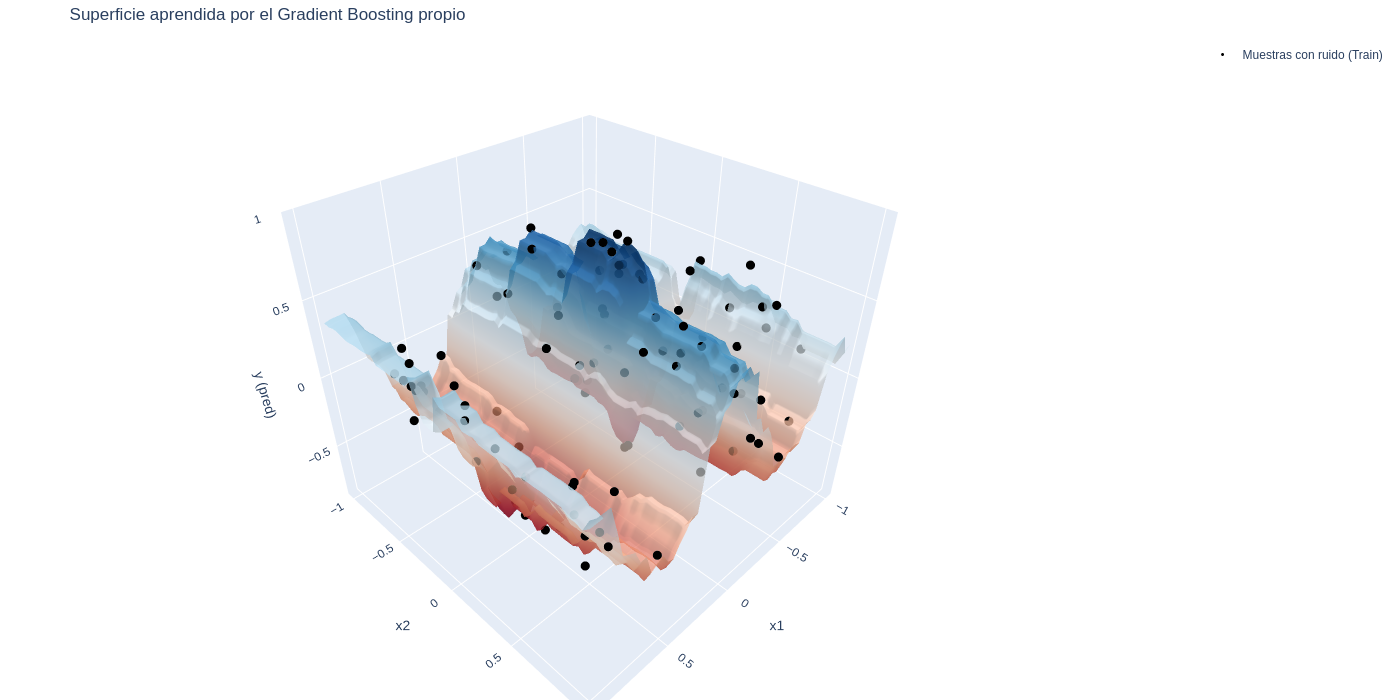

In [47]:
############################ Completar ############################
import plotly.graph_objects as go

# figura
fig = go.Figure()

# superficie aprendida
fig.add_trace(go.Surface(
    x=X1_mesh, 
    y=X2_mesh, 
    z=y_pred_grid,
    name='Superficie GBM',
    colorscale='RdBu',  
    opacity=0.7,        
    showscale=False
))

# puntos de entrenamiento
fig.add_trace(go.Scatter3d(
    x=x1, 
    y=x2, 
    z=y,
    name='Muestras con ruido (Train)',
    mode='markers',
    marker=dict(
        color='black',
        size=3 
    )
))

# layout (titulos y etiquetas pa los ejes)
fig.update_layout(
    title='Superficie aprendida por el Gradient Boosting propio',
    width=800,
    height=700,
    margin=dict(l=0, r=0, b=0, t=40),
    scene=dict(
        xaxis_title='x1',
        yaxis_title='x2',
        zaxis_title='y (pred)',
        aspectmode='data'
    ),
    showlegend=True
)

fig.show()